<a id="ref2"></a>
<U><h1><center>Movie Recommender Content Based Filtering</center></h1></U>

<center> by Kruti Shah </center>

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

###### Loading Data

In [4]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [7]:
#Drop removes a specified row or column from a dataframe
ratings_df = ratings_df.drop('timestamp', 1)
ratings_df.head()

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


#### There are multiple rating records in ratings_df for a particular movie by different users.The below code is to find an average rating for a particular movie

In [8]:
# Group by 'movieId' and calculate the average rating
average_ratings_df = ratings_df.groupby('movieId')['rating'].mean().reset_index()

# Display the DataFrame with average ratings
average_ratings_df.head(10)


,movieId,rating
0,1,3.907328
1,2,3.353261
2,3,3.189655
3,4,2.818182
4,5,3.250000
5,6,4.073913
6,7,3.381818
7,8,3.666667
8,9,2.869565
9,10,3.600000


In [9]:
rating = average_ratings_df[average_ratings_df['movieId'] == 131739]
print(rating)

       movieId  rating
10220   131739     3.5


###### Preprocessing movies dataframe

So each movie has a unique ID, a title with its release year along with it (Which may contain unicode characters) and several different genres in the same field. 

Let's remove the year from the __title__ column by using pandas' replace function and store in a new __year__ column.

Using regular expressions to find a year stored between parentheses<br>
We specify the parantheses so we don't conflict with movies that have years in their titles

In [10]:
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
movies_df['year']

0        (1995)
1        (1995)
2        (1995)
3        (1995)
4        (1995)
          ...  
10324    (2015)
10325    (1966)
10326    (2015)
10327    (2015)
10328    (2015)
Name: year, Length: 10329, dtype: object

In [11]:
#Removing paranthesis
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
movies_df['year']

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
10324    2015
10325    1966
10326    2015
10327    2015
10328    2015
Name: year, Length: 10329, dtype: object

In [12]:
movies_df['title']

0                           Toy Story (1995)
1                             Jumanji (1995)
2                    Grumpier Old Men (1995)
3                   Waiting to Exhale (1995)
4         Father of the Bride Part II (1995)
                        ...                 
10324          Cosmic Scrat-tastrophe (2015)
10325             Le Grand Restaurant (1966)
10326         A Very Murray Christmas (2015)
10327                   The Big Short (2015)
10328    Marco Polo: One Hundred Eyes (2015)
Name: title, Length: 10329, dtype: object

In [13]:
#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
movies_df['title']

0                           Toy Story 
1                             Jumanji 
2                    Grumpier Old Men 
3                   Waiting to Exhale 
4         Father of the Bride Part II 
                     ...              
10324          Cosmic Scrat-tastrophe 
10325             Le Grand Restaurant 
10326         A Very Murray Christmas 
10327                   The Big Short 
10328    Marco Polo: One Hundred Eyes 
Name: title, Length: 10329, dtype: object

In [14]:
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

In [15]:
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


With that, let's also split the values in the __Genres__ column into a __list of Genres__ to simplify future use. This can be achieved by applying Python's split string function on the correct column.

In [16]:
#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


Since keeping genres in a list format isn't optimal for the content-based recommendation system technique, we will use the One Hot Encoding technique to convert the list of genres to a vector where each column corresponds to one possible value of the feature. This encoding is needed for feeding categorical data. In this case, we store every different genre in columns that contain either 1 or 0. 1 shows that a movie has that genre and 0 shows that it doesn't. Let's also store this dataframe in another variable since genres won't be important for our first recommendation system.

In [17]:
import pandas as pd

# Assuming movies_df is your DataFrame with a 'genre' column
# Example DataFrame structure:
# movies_df = pd.DataFrame({
#     'movie_title': ['Movie1', 'Movie2', 'Movie3'],
#     'genre': [['Action', 'Adventure'], ['Action'], ['Adventure']]
# })

# Filter movies with both 'Action' and 'Adventure' genres
filtered_movies = movies_df[movies_df['genres'].apply(lambda x: 'Action' in x or 'Adventure' in x)] 
# Display the filtered DataFrame
#print(filtered_movies)
filtered_movies.tail(10)

,movieId,title,genres,year
10277,138104,Justice League: Gods and Monsters,"[Action, Animation]",2015
10283,139385,The Revenant,"[Adventure, Drama]",2015
10285,139620,Everything's Gonna Be Great,"[Adventure, Children, Comedy, Drama]",1998
10286,139642,Southpaw,"[Action, Drama]",2015
10289,139920,Women of the Prehistoric Planet,"[Action, Adventure, Sci-Fi]",1966
10294,140711,American Ultra,"[Action, Comedy]",2015
10297,140737,The Lost Room,"[Action, Fantasy, Mystery]",2006
10306,142448,Everest,"[Adventure, Drama, Thriller]",2015
10310,142550,Ryuzo and the Seven Henchmen,"[Action, Comedy]",2015
10318,143882,Operator,"[Action, Drama, Thriller]",2015


In [18]:
filtered_movies.shape

(2354, 4)

In [19]:
# Merge movies_df with average_ratings_df based on 'movieId'
merged_df = pd.merge(movies_df, average_ratings_df, on='movieId', how='left')

# Filter movies with 'Action' and 'Adventure' genres and rating 3 or more
filtered_movies = merged_df[
    merged_df['genres'].apply(lambda x: 'Action' in x or 'Adventure' in x) &
    (merged_df['rating'] >= 3)
]
filtered_movies.shape
# Display the filtered DataFrame
#filtered_movies.tail(15)

(1590, 5)

In [20]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres_df = movies_df.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
        
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,War,Musical,Documentary,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#Drop the genres other than 'Action and 'Adventure'
# List of genres to keep
cols_to_keep = ['movieId','title','genres','year','Action', 'Adventure']

# Create a list of columns to drop
columns_to_drop = [col for col in moviesWithGenres_df.columns if col not in cols_to_keep]

# Drop columns
moviesWithGenres_df.drop(columns=columns_to_drop, inplace=True)

# Display the updated DataFrame
print(moviesWithGenres_df)

       movieId                         title  \
0            1                     Toy Story   
1            2                       Jumanji   
2            3              Grumpier Old Men   
3            4             Waiting to Exhale   
4            5   Father of the Bride Part II   
...        ...                           ...   
10324   146684        Cosmic Scrat-tastrophe   
10325   146878           Le Grand Restaurant   
10326   148238       A Very Murray Christmas   
10327   148626                 The Big Short   
10328   149532  Marco Polo: One Hundred Eyes   

                                                  genres  year  Adventure  \
0      [Adventure, Animation, Children, Comedy, Fantasy]  1995        1.0   
1                         [Adventure, Children, Fantasy]  1995        1.0   
2                                      [Comedy, Romance]  1995        0.0   
3                               [Comedy, Drama, Romance]  1995        0.0   
4                                     

Next, let's look at the ratings dataframe.

In [22]:
ratings_df.head()

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


### Let's begin by creating an input user to recommend movies to:

Notice: To add more movies, simply increase the amount of elements in the __userInput__. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .

In [23]:

#userInput = [
#            {'title':'Breakfast Club, The', 'rating':5},
#            {'title':'Toy Story', 'rating':3.5},
#            {'title':'Jumanji', 'rating':2},
#            {'title':"Pulp Fiction", 'rating':5},
#            {'title':'Akira', 'rating':4.5}
#         ] 
#inputMovies = pd.DataFrame(userInput)
#inputMovies

In [24]:
userInput = [
            {'title':'Martian, The', 'rating':4},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Star Wars: Episode VII - The Force Awakens', 'rating':3.9},
            {'title':"The Last Witch Hunter", 'rating':3.0},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Martian, The",4.0
1,Toy Story,3.5
2,Star Wars: Episode VII - The Force Awakens,3.9
3,The Last Witch Hunter,3.0
4,Akira,4.5


In [25]:
title_of_movie = movies_df.loc[movies_df['movieId'].apply(lambda x: x == 131444), 'title'].values[0]

print(title_of_movie)

Rurouni Kenshin: The Legend Ends


### Add movieId to input user
With the input complete, let's extract the input movie's ID's from the movies dataframe and add them into it.

In [26]:
#Filtering out the movies by title
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]

inputId

#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)

#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)

inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,1274,Akira,4.5
2,122886,Star Wars: Episode VII - The Force Awakens,3.9
3,134130,"Martian, The",4.0
4,135532,The Last Witch Hunter,3.0


### Getting genre table for user movies

We're going to start by learning the input's preferences, so let's get the subset of movies that the input has watched from the Dataframe containing genres defined with binary values.

In [27]:
#Filtering out the movies from the input
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Action
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,0.0
1033,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0
10158,122886,Star Wars: Episode VII - The Force Awakens,"[Action, Adventure, Fantasy, Sci-Fi]",2015,1.0,1.0
10247,134130,"Martian, The","[Action, Adventure, Sci-Fi]",2015,1.0,1.0
10262,135532,The Last Witch Hunter,"[Action, Adventure, Fantasy]",2015,1.0,1.0


We'll only need the actual genre table, so let's clean this up a bit by resetting the index and dropping the movieId, title, genres and year columns.

In [28]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)

#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Action
0,1.0,0.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


### Start learning the input's preferences

To do this, we're going to turn each genre into weights. We can do this by using the input's reviews and multiplying them into the input's genre table and then summing up the resulting table by column. This operation is actually a dot product between a matrix and a vector, so we can simply accomplish by calling Pandas's "dot" function.

In [29]:
inputMovies['rating']

0    3.5
1    4.5
2    3.9
3    4.0
4    3.0
Name: rating, dtype: float64

In [30]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])

#The user profile
userProfile

Adventure    18.9
Action       15.4
dtype: float64

Now, we have the weights for every of the user's preferences. This is known as the User Profile. Using this, we can recommend movies that satisfy the user's preferences.

Let's start by extracting the genre table from the original dataframe:

In [31]:
userMovies['title'][3]

'Martian, The'

In [32]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
genreTable = genreTable.reset_index(drop=True)
genreTableF = genreTable.drop('genres', 1).drop('year', 1)
genreTable = genreTable.drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,movieId,Adventure,Action
0,1,1.0,0.0
1,2,1.0,0.0
2,3,0.0,0.0
3,4,0.0,0.0
4,5,0.0,0.0


In [33]:
genreTable.shape

(10329, 3)

In [34]:
genreTable.tail(10)

,movieId,Adventure,Action
10319,144482,0.0,0.0
10320,144656,0.0,0.0
10321,144976,0.0,0.0
10322,146344,0.0,0.0
10323,146656,0.0,0.0
10324,146684,0.0,0.0
10325,146878,0.0,0.0
10326,148238,0.0,0.0
10327,148626,0.0,0.0
10328,149532,0.0,0.0


In [35]:
#And drop the unnecessary information
#genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
#genreTable.head()

In [36]:
genreTable.shape

(10329, 3)

In [37]:
genreTable['movieId']

0             1
1             2
2             3
3             4
4             5
          ...  
10324    146684
10325    146878
10326    148238
10327    148626
10328    149532
Name: movieId, Length: 10329, dtype: int64

With the input's profile and the complete list of movies and their genres in hand, we're going to take the weighted average of every movie based on the input profile and recommend the top twenty movies that most satisfy it.

In [38]:
#Multiply the genres by the weights and then take the weighted average
#recommendationTable_df  = pd.DataFrame('recommendation_percentage'}
recommendationTable_df  = pd.DataFrame({'movieId':[], 'recommendation_percentage':[]})
recommendationTable_df['movieId'] = genreTable['movieId']
recommendationTable_df['recommendation_percentage'] = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())*100
recommendationTable_df.head(100)
#new_df = recommendationTable_df.rename({"": 'recommendation_percentage'}, axis=1)
#new_df
recommendationTable_df.shape
recommendationTable_df.tail()

,movieId,recommendation_percentage
10324,146684,0.0
10325,146878,0.0
10326,148238,0.0
10327,148626,0.0
10328,149532,0.0


In [39]:
#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(by = 'recommendation_percentage',ascending=False)

#Just a peek at the values
recommendationTable_df.head(100)

,movieId,recommendation_percentage
1050,1291,100.0
9685,102880,100.0
7379,53004,100.0
1976,2471,100.0
7384,53125,100.0
...,...,...
4089,5313,100.0
8989,86880,100.0
7035,45722,100.0
9642,101864,100.0


### Now here's the recommendation table!

In [40]:
#The final recommendation table
Top10_df = recommendationTable_df.tail(10)
Top10_df = Top10_df.rename(columns={'movieid': 'movieId'})
Top10_df

final_df = movies_df.loc[movies_df['movieId'].isin(Top10_df['movieId'])]
final_df = pd.merge(final_df, Top10_df, on='movieId', how='left')
final_df

,movieId,title,genres,year,recommendation_percentage
0,4977,Kandahar (Safar e Ghandehar),[Drama],2001,0.0
1,4978,Lantana,"[Drama, Mystery, Thriller]",2001,0.0
2,4979,"Royal Tenenbaums, The","[Comedy, Drama]",2001,0.0
3,4981,Clockwise,[Comedy],1986,0.0
4,4982,"Crawling Eye, The (a.k.a. Trollenberg Terror, ...","[Horror, Sci-Fi]",1958,0.0
5,4984,Morgan!,"[Comedy, Drama, Fantasy]",1966,0.0
6,4989,How High,[Comedy],2001,0.0
7,4991,Joe Somebody,"[Comedy, Drama, Romance]",2001,0.0
8,4992,Kate & Leopold,"[Comedy, Romance]",2001,0.0
9,149532,Marco Polo: One Hundred Eyes,[(no genres listed)],2015,0.0


### Advantages and Disadvantages of Content-Based Filtering

##### Advantages
* Learns user's preferences
* Highly personalized for the user

##### Disadvantages
* Doesn't take into account what others think of the item, so low quality item recommendations might happen
* Extracting data is not always intuitive
* Determining what characteristics of the item the user dislikes or likes is not always obvious

## Recommender  Fuzzy Inference System - Mamdani

In [41]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [42]:


# Assuming selected_genre_df DataFrame has columns 'movieId', 'title', 'Action', 'Adventure'
# Assuming ratings_df DataFrame has columns 'movieId', 'rating'

# Specify columns to copy
selected_columns = ['movieId','title', 'Action', 'Adventure']

# Create a new DataFrame with selected columns
selected_genre_df = genreTableF[selected_columns].copy()

selected_genre_df.tail(10)

,movieId,title,Action,Adventure
10319,144482,Circle,0.0,0.0
10320,144656,The Measure of a Man,0.0,0.0
10321,144976,Bone Tomahawk,0.0,0.0
10322,146344,Elämältä kaiken sain ( ),0.0,0.0
10323,146656,Creed,0.0,0.0
10324,146684,Cosmic Scrat-tastrophe,0.0,0.0
10325,146878,Le Grand Restaurant,0.0,0.0
10326,148238,A Very Murray Christmas,0.0,0.0
10327,148626,The Big Short,0.0,0.0
10328,149532,Marco Polo: One Hundred Eyes,0.0,0.0


In [43]:
# Check for and drop duplicates in 'movieId' in both DataFrames
#selected_genre_df.drop_duplicates(subset='movieId', inplace=True)
#ratings_df.drop_duplicates(subset='movieId', inplace=True)

# Merge with ratings_df based on 'movieId'
selected_genre_df = pd.merge(selected_genre_df, average_ratings_df, on='movieId', how='left')

# Display the new DataFrame with ratings
#print(selected_genre_df)
selected_genre_df.head(20)

,movieId,title,Action,Adventure,rating
0,1,Toy Story,0.0,1.0,3.907328
1,2,Jumanji,0.0,1.0,3.353261
2,3,Grumpier Old Men,0.0,0.0,3.189655
3,4,Waiting to Exhale,0.0,0.0,2.818182
4,5,Father of the Bride Part II,0.0,0.0,3.250000
5,6,Heat,1.0,0.0,4.073913
6,7,Sabrina,0.0,0.0,3.381818
7,8,Tom and Huck,0.0,1.0,3.666667
8,9,Sudden Death,1.0,0.0,2.869565
9,10,GoldenEye,1.0,1.0,3.600000


## Fuzzification

### Now, let's briefly discuss the differences between gaussmf, trimf, and automf:

gaussmf (Gaussian Membership Function): It represents a Gaussian-shaped membership function. It takes three parameters: the mean (center of the curve), the standard deviation (width of the curve), and the input universe.

trimf (Triangular Membership Function): It represents a triangular-shaped membership function. It takes three parameters: the lower bound, the peak (mode), and the upper bound of the triangle.

automf (Automatic Membership Function): It is a convenience function in scikit-fuzzy that automatically generates membership functions based on predefined shapes (like 'poor', 'mediocre', 'average', 'good', 'excellent'). It is often used for quick and simple fuzzy systems where you don't want to manually specify membership function parameters.

In the provided code, I used gaussmf for rating and binary genre variables, and trimf for the recommendation output. You can choose the appropriate membership function based on the characteristics you want to capture for each variable in your fuzzy system.

In [44]:
# Input variables
rating = ctrl.Antecedent(np.arange(0, 6, 1), 'rating')
genre_action = ctrl.Antecedent(np.arange(0, 2, 1), 'genre_action')  # 0 or 1 for 'Action'
genre_adventure = ctrl.Antecedent(np.arange(0, 2, 1), 'genre_adventure')  # 0 or 1 for 'Adventure'

# Output variable
recommendation = ctrl.Consequent(np.arange(0, 101, 1),'recommendation')


# Define membership functions using gaussmf
rating['low'] = fuzz.gaussmf(rating.universe, 0, 1)
rating['medium'] = fuzz.gaussmf(rating.universe, 3, 1)
rating['high'] = fuzz.gaussmf(rating.universe, 5, 1)

# Define membership functions using trimf
genre_action['not_present'] = fuzz.trimf(genre_action.universe,[0, 0, 1])
genre_action['present'] = fuzz.trimf(genre_action.universe, [0, 1, 1])

genre_adventure['not_present'] = fuzz.trimf(genre_adventure.universe,[0, 0, 1])
genre_adventure['present'] = fuzz.trimf(genre_adventure.universe, [0, 1, 1])


# Define membership functions using trimf
recommendation['low'] = fuzz.trimf(recommendation.universe, [0, 0, 50])
recommendation['medium'] = fuzz.trimf(recommendation.universe, [10, 50, 90])
recommendation['high'] = fuzz.trimf(recommendation.universe, [50, 100, 100])




In [45]:
# Rule base
rule1 = ctrl.Rule(rating['low'] & genre_action['not_present'] & genre_adventure['not_present'], recommendation['low'])
rule2 = ctrl.Rule(rating['low'] & genre_action['not_present'] & genre_adventure['present'], recommendation['low'])
rule3 = ctrl.Rule(rating['low'] & genre_action['present'] & genre_adventure['not_present'], recommendation['low'])
rule4 = ctrl.Rule(rating['low'] & genre_action['present'] & genre_adventure['present'], recommendation['medium'])

rule5 =  ctrl.Rule(rating['medium'] & genre_action['not_present'] & genre_adventure['not_present'], recommendation['low'])
rule6 = ctrl.Rule(rating['medium'] & genre_action['not_present'] & genre_adventure['present'], recommendation['medium'])
rule7 = ctrl.Rule(rating['medium'] & genre_action['present'] & genre_adventure['not_present'], recommendation['medium'])
rule8 = ctrl.Rule(rating['medium'] & genre_action['present'] & genre_adventure['present'], recommendation['high'])

rule9 =  ctrl.Rule(rating['high'] & genre_action['not_present'] & genre_adventure['not_present'], recommendation['low'])
rule10 = ctrl.Rule(rating['high'] & genre_action['not_present'] & genre_adventure['present'], recommendation['medium'])
rule11 = ctrl.Rule(rating['high'] & genre_action['present'] & genre_adventure['not_present'], recommendation['medium'])
rule12 = ctrl.Rule(rating['high'] & genre_action['present'] & genre_adventure['present'], recommendation['high'])




(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

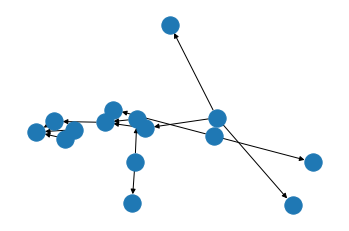

In [46]:
rule1.view()

## Fuzzy Control System
 The code below is the heart of the Fuzzy controller system where it inputs from every row of selected_genre_df and calculates the recommendation % based on the rules provided. The skfuzzy control system uses the ControlSystem Simulation to  defuzzify the rules and it provides a crisp recommendation percentage. The recommendationTableF_df is sorted and the top 10 movies are shown as recommended. 

In [47]:
# Control system
recommendation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12])

recommendation_sys = ctrl.ControlSystemSimulation(recommendation_ctrl)


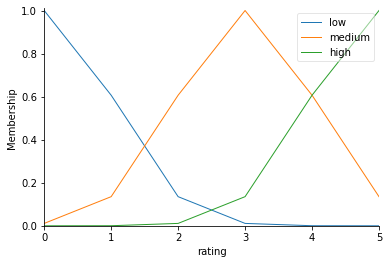

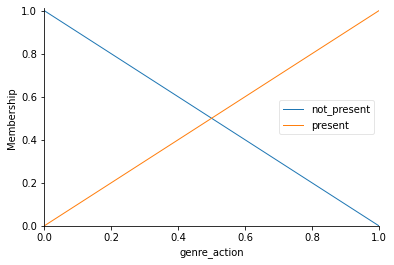

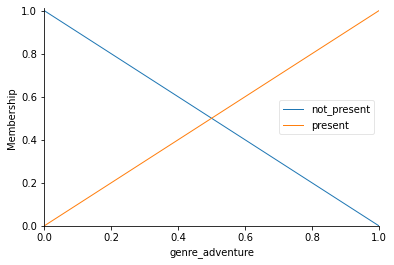

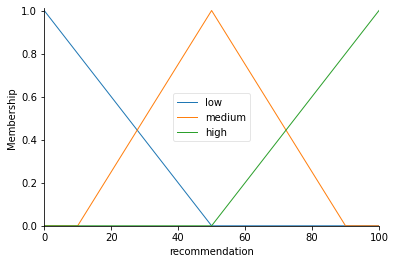

In [48]:
#visualize membership function
rating.view(sim =recommendation_sys)
plt.show()

genre_action.view(sim =recommendation_sys)
plt.show()

genre_adventure.view(sim =recommendation_sys)
plt.show()

recommendation.view(sim =recommendation_sys)
plt.show()

In [49]:
# Assuming 'inputMovie' DataFrame has 'movieId', 'rating'
# Assuming 'genreTable' DataFrame has 'movieId', 'Action', 'Adventure'
recommendationTableF_df = pd.DataFrame(columns=['movieId','recommendation_percentage'])

# Iterate over rows in inputMovie
for index, row in selected_genre_df.iterrows():
    movie_id = row['movieId']
    input_rating = row['rating']

    # Set input values from inputMovie DataFrame
    recommendation_sys.input['rating'] = input_rating

    # Set input values from genreTable DataFrame
    input_action = row['Action']
    input_adventure = row['Adventure']
    recommendation_sys.input['genre_action'] = input_action
    recommendation_sys.input['genre_adventure'] = input_adventure

    # Compute the recommendation
    recommendation_sys.compute()

    # Access the output
    recommendation = recommendation_sys.output['recommendation']
    
    # Append to recommendationTableF_df
    recommendationTableF_df = recommendationTableF_df.append({
        'movieId': movie_id,
        'recommendation_percentage': recommendation
    }, ignore_index=True)
    
# Print the resulting DataFrame
print(recommendationTableF_df)    
    

        movieId  recommendation_percentage
0           1.0                  49.982051
1           2.0                  49.912699
2           3.0                  16.753033
3           4.0                  16.746271
4           5.0                  16.813493
...         ...                        ...
10324  146684.0                  18.518377
10325  146878.0                  17.205696
10326  148238.0                  16.666667
10327  148626.0                  17.575158
10328  149532.0                  18.518377

[10329 rows x 2 columns]


In [51]:
recommendationTableF_df.tail(10)

,movieId,recommendation_percentage
10319,144482.0,16.666667
10320,144656.0,17.205696
10321,144976.0,16.666667
10322,146344.0,18.518377
10323,146656.0,17.205696
10324,146684.0,18.518377
10325,146878.0,17.205696
10326,148238.0,16.666667
10327,148626.0,17.575158
10328,149532.0,18.518377


In [52]:

#Sort our recommendations in descending order
recommendationTableF_df = recommendationTableF_df.sort_values(by='recommendation_percentage',ascending=False)

#Just a peek at the values
recommendationTableF_df

,movieId,recommendation_percentage
6459,31367.0,83.333013
4337,5720.0,83.333013
9902,108979.0,82.936013
8041,66785.0,82.779293
6031,26012.0,82.779293
...,...,...
6429,30949.0,16.666667
4878,6660.0,16.666667
2904,3679.0,16.666667
8902,85022.0,16.666667


In [54]:
Top10f_df = recommendationTableF_df.head(10)
Top10f_df

,movieId,recommendation_percentage
6459,31367.0,83.333013
4337,5720.0,83.333013
9902,108979.0,82.936013
8041,66785.0,82.779293
6031,26012.0,82.779293
9933,110216.0,82.779293
9700,103210.0,82.779293
6288,27155.0,82.779293
4912,6721.0,82.779293
2323,2905.0,82.628177


In [60]:
#The final recommendation table
finalf_df = movies_df.loc[movies_df['movieId'].isin(Top10f_df['movieId'])]

finalf_df = pd.merge(finalf_df, Top10f_df, on='movieId', how='left')
#finalf_df
finalf_df = finalf_df.sort_values(by='recommendation_percentage',ascending=False)
finalf_df

,movieId,title,genres,year,recommendation_percentage
1,5720,"Friend Is a Treasure, A (Chi Trova Un Amico, T...","[Action, Adventure, Comedy]",1981,83.333013
5,31367,"Chase, The","[Action, Adventure, Comedy, Crime, Romance, Th...",1994,83.333013
8,108979,Cowboy Bebop,"[Action, Adventure, Animation, Crime, Sci-Fi]",1998,82.936013
2,6721,Once Upon a Time in China (Wong Fei Hung),"[Action, Adventure, Drama]",1991,82.779293
3,26012,Samurai III: Duel on Ganryu Island (a.k.a. Bus...,"[Action, Adventure, Drama]",1956,82.779293
4,27155,"Batman/Superman Movie, The","[Action, Adventure, Animation, Children, Fanta...",1998,82.779293
6,66785,"Good, the Bad, the Weird, The (Joheunnom nabbe...","[Action, Adventure, Comedy, Western]",2008,82.779293
7,103210,Fullmetal Alchemist: The Sacred Star of Milos,"[Action, Adventure, Animation]",2011,82.779293
9,110216,BloodRayne: The Third Reich,"[Action, Adventure, Fantasy, Horror]",2011,82.779293
0,2905,Sanjuro (Tsubaki Sanjûrô),"[Action, Adventure, Drama]",1962,82.628177


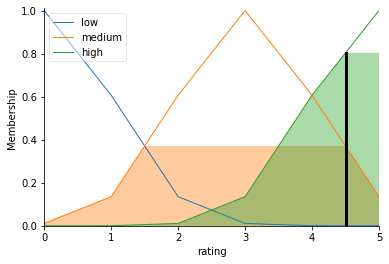

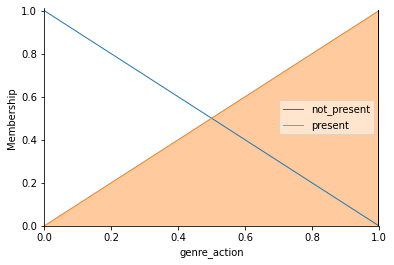

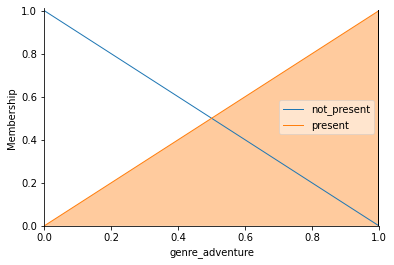

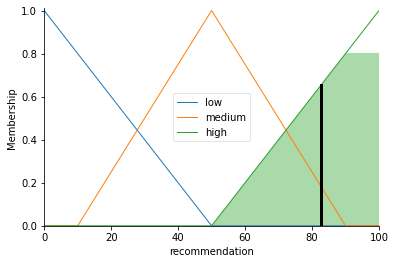

In [53]:
recommendation_sys.input['rating']   = 4.5
recommendation_sys.input['genre_action'] = 1
recommendation_sys.input['genre_adventure'] = 1

recommendation_sys.compute()

# Visualize membership functions and the simulation
for var in recommendation_sys.ctrl.antecedents:
    var.view(sim=recommendation_sys)

for var in recommendation_sys.ctrl.consequents:
    var.view(sim=recommendation_sys)

# Show the plots
plt.show()